<a href="https://colab.research.google.com/github/Thenmozhi2212/Fish_image_classification/blob/main/finaltransfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
##### final model

In [ ]:
# =======================================================
# 📦 IMPORTS
# =======================================================
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import os

# =======================================================
# 🧭 PATH SETUP
# =======================================================
base_dir = "/content/images.cv_jzk6llhf18tm3k0kyttxz/data"
train_dir = os.path.join(base_dir, "train")
val_dir = os.path.join(base_dir, "val")
test_dir = os.path.join(base_dir, "test")

# =======================================================
# 🎨 DATA AUGMENTATION
# =======================================================
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=25,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)

# =======================================================
# 🖼️ DATA GENERATORS
# =======================================================
batch_size = 32
img_size = (224, 224)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

# =======================================================
# ⚖️ CLASS WEIGHTS (for imbalance)
# =======================================================
class_indices = train_generator.class_indices
class_labels = list(class_indices.keys())

# Get labels for all samples in the generator
train_labels = train_generator.classes
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_labels),
    y=train_labels
)
class_weights = dict(enumerate(class_weights))

print("\n✅ Computed Class Weights:")
for cls, weight in zip(class_labels, class_weights.values()):
    print(f"{cls}: {weight:.2f}")

# =======================================================
# 🧠 MODEL BUILDING (EfficientNetB3)
# =======================================================
base_model = EfficientNetB3(
    weights='imagenet', include_top=False, input_shape=(224, 224, 3)
)

# Unfreeze some layers for fine-tuning
for layer in base_model.layers[-60:]:
    layer.trainable = True

# Model architecture
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.BatchNormalization(),
    layers.Dropout(0.4),
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(len(class_labels), activation='softmax')
])

# =======================================================
# ⚙️ COMPILE MODEL
# =======================================================
optimizer = optimizers.Adam(learning_rate=1e-4)
model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

# =======================================================
# 🧩 CALLBACKS
# =======================================================
callbacks = [
    EarlyStopping(monitor='val_accuracy', patience=6, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=3, min_lr=1e-6)
]

# =======================================================
# 🚀 TRAIN MODEL
# =======================================================
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=30,
    class_weight=class_weights,
    callbacks=callbacks
)

# =======================================================
# 💾 SAVE MODEL
# =======================================================
model.save("efficientnetb3_fish_classifier.h5")

# =======================================================
# 📈 PLOT TRAINING PERFORMANCE
# =======================================================
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy Over Epochs')
plt.legend()
plt.show()


Found 6225 images belonging to 11 classes.
Found 1092 images belonging to 11 classes.

✅ Computed Class Weights:
animal fish: 0.52
animal fish bass: 18.86
fish sea_food black_sea_sprat: 0.99
fish sea_food gilt_head_bream: 1.00
fish sea_food hourse_mackerel: 0.99
fish sea_food red_mullet: 0.98
fish sea_food red_sea_bream: 0.99
fish sea_food sea_bass: 1.05
fish sea_food shrimp: 0.98
fish sea_food striped_red_mullet: 1.03
fish sea_food trout: 0.98
43941136/43941136 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb3 (Functional)     │ (None, 7, 7, 1536)     │    10,783,535 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1536)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1536)           │         6,144 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1536)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       393,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 11)             │         2,827 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,187,002 (42.68 MB)

 Trainable params: 11,096,115 (42.33 MB)

 Non-trainable params: 90,887 (355.03 KB)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
195/195 ━━━━━━━━━━━━━━━━━━━━ 313s 952ms/step - accuracy: 0.4050 - loss: 1.9637 - val_accuracy: 0.1685 - val_loss: 2.9285 - learning_rate: 1.0000e-04
Epoch 2/30
195/195 ━━━━━━━━━━━━━━━━━━━━ 92s 472ms/step - accuracy: 0.9065 - loss: 0.2550 - val_accuracy: 0.7152 - val_loss: 0.8256 - learning_rate: 1.0000e-04
Epoch 3/30
195/195 ━━━━━━━━━━━━━━━━━━━━ 93s 475ms/step - accuracy: 0.9640 - loss: 0.1076 - val_accuracy: 0.8379 - val_loss: 0.5376 - learning_rate: 1.0000e-04
Epoch 4/30
195/195 ━━━━━━━━━━━━━━━━━━━━ 92s 469ms/step - accuracy: 0.9776 - loss: 0.0717 - val_accuracy: 0.0769 - val_loss: 6.4706 - learning_rate: 1.0000e-04
Epoch 5/30
195/195 ━━━━━━━━━━━━━━━━━━━━ 93s 475ms/step - accuracy: 0.9858 - loss: 0.0448 - val_accuracy: 0.0714 - val_loss: 5.5477 - learning_rate: 1.0000e-04
Epoch 6/30
195/195 ━━━━━━━━━━━━━━━━━━━━ 92s 473ms/step - accuracy: 0.9801 - loss: 0.0611 - val_accuracy: 0.0925 - val_loss: 4.9937 - learning_rate: 1.0000e-04
Epoch 7/30
195/195 ━━━━━━━━━━━━━━━━━━━━ 92s 4

KeyboardInterrupt: 

In [ ]:
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

test_loss, test_acc = model.evaluate(test_generator)
print(f"✅ Test Accuracy: {test_acc:.2%}")


Found 3187 images belonging to 11 classes.
100/100 ━━━━━━━━━━━━━━━━━━━━ 23s 234ms/step - accuracy: 0.9755 - loss: 0.0826
✅ Test Accuracy: 98.49%


100/100 ━━━━━━━━━━━━━━━━━━━━ 26s 166ms/step


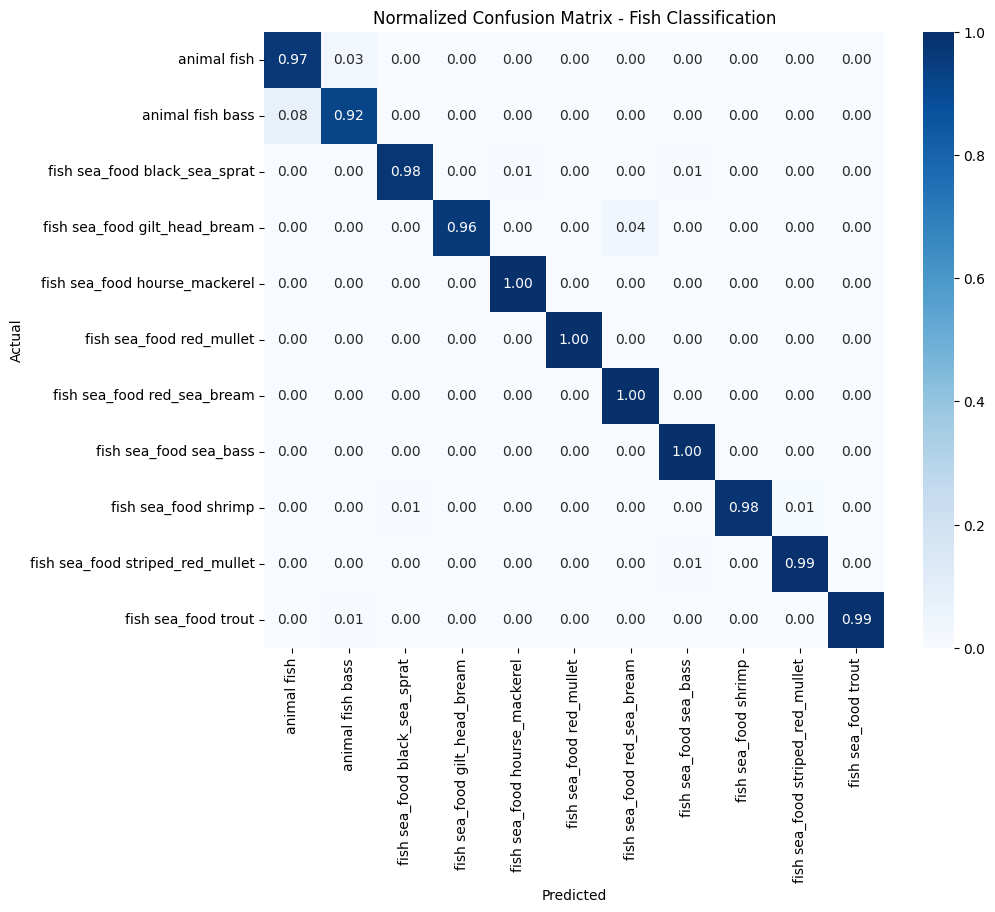

📋 Classification Report:
                                  precision    recall  f1-score   support

                     animal fish       1.00      0.97      0.98       520
                animal fish bass       0.39      0.92      0.55        13
   fish sea_food black_sea_sprat       0.99      0.98      0.99       298
   fish sea_food gilt_head_bream       0.99      0.96      0.98       305
   fish sea_food hourse_mackerel       0.99      1.00      0.99       286
        fish sea_food red_mullet       1.00      1.00      1.00       291
     fish sea_food red_sea_bream       0.96      1.00      0.98       273
          fish sea_food sea_bass       0.99      1.00      0.99       327
            fish sea_food shrimp       1.00      0.98      0.99       289
fish sea_food striped_red_mullet       0.98      0.99      0.99       293
             fish sea_food trout       1.00      0.99      0.99       292

                        accuracy                           0.98      3187
           

In [ ]:
# =====================================================
# 🔍 CONFUSION MATRIX + CLASSIFICATION REPORT
# =====================================================
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Predict on test data
test_generator.reset()
preds = model.predict(test_generator, verbose=1)
y_pred = np.argmax(preds, axis=1)
y_true = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# Confusion matrix (normalized)
cm = confusion_matrix(y_true, y_pred, normalize='true')
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt=".2f", cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title("Normalized Confusion Matrix - Fish Classification")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Classification report
print("📋 Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_labels))


In [ ]:
import pickle

# Save class indices (used for decoding predictions later)
class_labels = list(train_generator.class_indices.keys())

with open("class_labels.pkl", "wb") as f:
    pickle.dump(class_labels, f)

print("✅ Class labels saved successfully!")


✅ Class labels saved successfully!


In [ ]:
from tensorflow.keras.models import load_model
import pickle


model.save("fish_classification_model.keras")
print("✅ Model saved as fish_classification_model.keras")


class_labels = train_generator.class_indices
class_labels = list(class_labels.keys())

with open("class_labels.pkl", "wb") as f:
    pickle.dump(class_labels, f)
print("✅ Class labels saved as class_labels.pkl")


✅ Model saved as fish_classification_model.keras
✅ Class labels saved as class_labels.pkl


In [ ]:
from google.colab import files
files.download("fish_classification_model.keras")
files.download("class_labels.pkl")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import pickle

# Load class labels
with open("/content/class_labels.pkl", "rb") as f:
    class_labels = pickle.load(f)

num_classes = len(class_labels)  # number of fish categories
print(f"Number of classes: {num_classes}")


Number of classes: 11


In [ ]:
import os
import pickle
import numpy as np
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# -----------------------------
# Paths
# -----------------------------
test_dir= "/content/images.cv_jzk6llhf18tm3k0kyttxz/data/test"
val_dir= "/content/images.cv_jzk6llhf18tm3k0kyttxz/data/val"
train_dir= "/content/images.cv_jzk6llhf18tm3k0kyttxz/data/train"

LABELS_PATH = "/content/class_labels.pkl"
MODEL_SAVE_PATH = "/content/fish_classification_model.keras"

# -----------------------------
# Load class labels
# -----------------------------
with open(LABELS_PATH, "rb") as f:
    class_labels = pickle.load(f)

num_classes = len(class_labels)
print(f"Number of classes: {num_classes}")

# -----------------------------
# Image Data Generators
# -----------------------------
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    validation_split=0.2  # 80% train, 20% validation
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(225, 225),
    batch_size=32,
    class_mode='categorical',
    subset='training',
    color_mode='rgb',
    classes=class_labels
)

validation_generator = train_datagen.flow_from_directory(
    val_dir,
    target_size=(225, 225),
    batch_size=32,
    class_mode='categorical',
    subset='validation',
    color_mode='rgb',
    classes=class_labels
)
test_generator= train_datagen.flow_from_directory(
    test_dir,
    target_size=(225, 225),
    batch_size=32,
    class_mode='categorical',
    subset='validation',
    color_mode='rgb',
    classes=class_labels
)
# -----------------------------
# Build the model
# -----------------------------
input_shape = (225, 225, 3)  # RGB images
inputs = layers.Input(shape=input_shape)

x = layers.Conv2D(32, (3,3), activation='relu')(inputs)
x = layers.MaxPooling2D((2,2))(x)
x = layers.Conv2D(64, (3,3), activation='relu')(x)
x = layers.MaxPooling2D((2,2))(x)
x = layers.Flatten()(x)
x = layers.Dense(128, activation='relu')(x)
outputs = layers.Dense(num_classes, activation='softmax')(x)

model = models.Model(inputs=inputs, outputs=outputs)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

# -----------------------------
# Train the model
# -----------------------------
epochs = 20
model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=epochs
)

# -----------------------------
# Save the model
# -----------------------------
model.save(MODEL_SAVE_PATH)
print(f"✅ Model saved to {MODEL_SAVE_PATH}")


Number of classes: 11
Found 4984 images belonging to 11 classes.
Found 215 images belonging to 11 classes.
Found 633 images belonging to 11 classes.


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 225, 225, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 223, 223, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 186624)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 128)            │    23,888,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 11)             │         1,419 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,908,811 (91.20 MB)

 Trainable params: 23,908,811 (91.20 MB)

 Non-trainable params: 0 (0.00 B)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 72s 427ms/step - accuracy: 0.2699 - loss: 3.0588 - val_accuracy: 0.5535 - val_loss: 1.2861
Epoch 2/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 61s 394ms/step - accuracy: 0.5729 - loss: 1.2150 - val_accuracy: 0.5581 - val_loss: 1.1047
Epoch 3/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 62s 400ms/step - accuracy: 0.6762 - loss: 0.9330 - val_accuracy: 0.7953 - val_loss: 0.7031
Epoch 4/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 62s 394ms/step - accuracy: 0.7811 - loss: 0.6721 - val_accuracy: 0.7814 - val_loss: 0.6488
Epoch 5/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 64s 405ms/step - accuracy: 0.8174 - loss: 0.5228 - val_accuracy: 0.8419 - val_loss: 0.5234
Epoch 6/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 62s 395ms/step - accuracy: 0.8399 - loss: 0.4619 - val_accuracy: 0.8186 - val_loss: 0.6184
Epoch 7/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 62s 395ms/step - accuracy: 0.8777 - loss: 0.3964 - val_accuracy: 0.8465 - val_loss: 0.5726
Epoch 8/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 62s 395ms/step - accuracy: 0.8733 - loss: 0

In [ ]:
from tensorflow.keras import layers, models

# Example for a small CNN
input_shape = (225, 225, 3)  # 3 channels for RGB
inputs = layers.Input(shape=input_shape)

x = layers.Conv2D(32, (3, 3), activation='relu')(inputs)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(64, (3, 3), activation='relu')(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Flatten()(x)
x = layers.Dense(128, activation='relu')(x)
outputs = layers.Dense(num_classes, activation='softmax')(x)

model = models.Model(inputs=inputs, outputs=outputs)
